# Working with Images & Logistic Regression in PyTorch

## Working with Images



In this tutorial, we'll use our existing knowledge of PyTorch and linear regression to solve a very different kind of problem: image classification. We'll use the famous MNIST Handwritten Digits Database as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

<img src="files/CAYnuo1.jpg">

We begin by installing and importing `torch` and `torchvision`. `torchvision `contains some utilities for working with image data. It also provides helper classes to download and import popular datasets like MNIST automatically



In [3]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [4]:
# Download training dataset
dataset=MNIST(root='data/', download=True)

100.0%


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



102.8%


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



112.7%


Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw

Processing...


C:\Users\fb\.conda\envs\fx\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [6]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the MNIST class by passing `train=False` to the constructor.

In [7]:
test_dataset=MNIST(root='data/', train=False)
len(test_dataset)

10000

In [8]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1CBC93D8520>, 5)

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class PIL.Image.Image, which is a part of the Python imaging library `Pillow`. We can view the image within Jupyter using `matplotlib`, the de-facto plotting and graphing library for data science in Python.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

The statement `%matplotlib` inline indicates to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with `%` are called magic commands and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

Label: 5


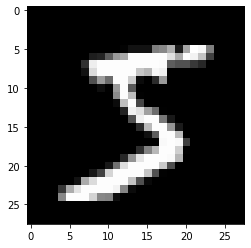

In [12]:
image,label=dataset[0]
plt.imshow(image,cmap='gray')
print('Label:', label)

Label: 3


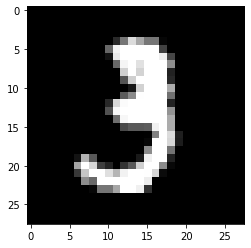

In [16]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [17]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [20]:
# MNIST dataset (images and labels)
dataset=MNIST(root='data/', 
              train=True, 
              transform=transforms.ToTensor())

In [21]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

Let's look at some sample values inside the tensor.

In [23]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor),torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white, and the values in between different shades of grey. We can also plot the tensor as an image using plt.imshow.

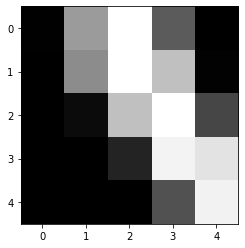

In [26]:
plt.imshow(img_tensor[0,10:15,10:15],cmap='gray')

Note that we need to pass just the 28x28 matrix to `plt.imshow`, without a channel dimension. We also pass a color map (`cmap=gray`) to indicate that we want to see a grayscale image.

## Training and Validation Datasets


While building real-world machine learning models, it is quite common to split the dataset into three parts:

- Training set - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
- Validation set - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
- Test set - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [27]:
from torch.utils.data import random_split
train_ds,val_ds = random_split(dataset,[50000,10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [28]:
from torch.utils.data import DataLoader
batch_size=128

train_loader=DataLoader(train_ds, batch_size, shuffle=True)
val_loader=DataLoader(val_ds, batch_size)

We set `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

## Model
Now that we have prepared our data loaders, we can define our model.

- A **logistic regression model** is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`).

- As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

- Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

- The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [30]:
import torch.nn as nn

input_size= 28*28
num_classes = 10

#Logistic regression model
model=nn.Linear(input_size,num_classes)

Of course, this model is a lot larger than our previous model in terms of the number of parameters. Let's take a look at the weights and biases.

In [34]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0264,  0.0003,  0.0105,  ...,  0.0183, -0.0047, -0.0182],
        [ 0.0201,  0.0208, -0.0006,  ..., -0.0039, -0.0091,  0.0149],
        [-0.0248,  0.0079, -0.0242,  ...,  0.0245,  0.0272, -0.0104],
        ...,
        [-0.0209, -0.0301, -0.0067,  ...,  0.0336, -0.0114, -0.0296],
        [ 0.0128, -0.0181, -0.0124,  ..., -0.0056,  0.0319,  0.0099],
        [ 0.0055,  0.0132, -0.0229,  ..., -0.0334, -0.0352, -0.0220]],
       requires_grad=True)

In [36]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0044, -0.0180,  0.0333, -0.0272,  0.0003,  0.0246, -0.0288,  0.0210,
         0.0060, -0.0233], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.



In [43]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([0, 8, 1, 2, 4, 8, 3, 4, 1, 6, 5, 7, 9, 5, 6, 8, 8, 9, 0, 0, 1, 8, 1, 1,
        3, 8, 9, 9, 5, 0, 6, 1, 4, 6, 7, 3, 2, 7, 9, 1, 5, 5, 1, 0, 5, 6, 6, 7,
        2, 4, 4, 9, 6, 9, 5, 6, 1, 7, 0, 7, 7, 1, 9, 2, 9, 7, 6, 4, 8, 8, 6, 6,
        9, 5, 8, 6, 9, 1, 8, 6, 1, 5, 8, 9, 8, 7, 8, 4, 9, 1, 7, 0, 2, 8, 8, 2,
        9, 1, 2, 7, 2, 2, 8, 2, 5, 7, 1, 2, 8, 4, 6, 3, 7, 5, 1, 1, 5, 7, 1, 4,
        0, 8, 0, 8, 0, 8, 6, 0])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

In [44]:
images.shape

torch.Size([128, 1, 28, 28])

In [48]:
images.reshape(128, 784).shape

torch.Size([128, 784])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch.

A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

In [50]:
class Person:
    #Class constructor
    def _init_(self,name,age):
        self.name = name
        self.age = age
    #Method
    def say_hello(self):
        print("hello my name is"+self.name+"!")

In [ ]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

**Farrukh Bulbulov**